In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

# %matplotlib widget

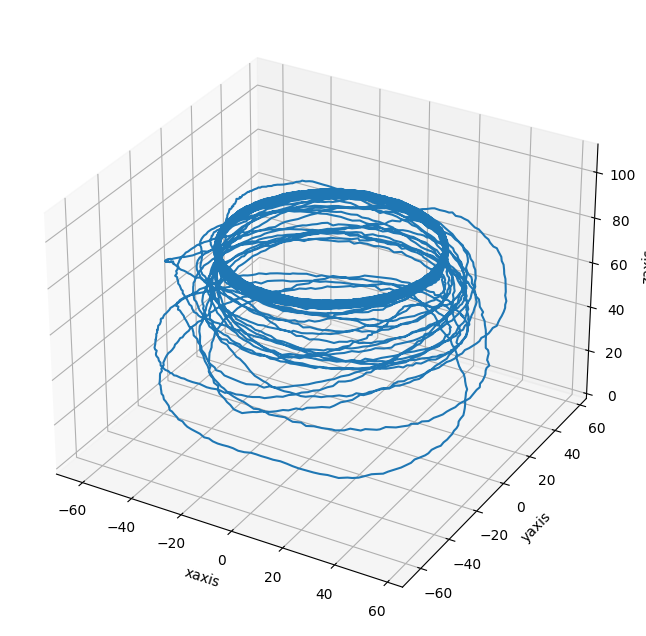

In [25]:

def plot_trajectory(filename : str):
    
    trajectory = []

    with open("data/" + filename + ".a") as file:
        for l, line, in enumerate(file):
            if l >= 10:
                trajectory.append(line.split()[1:4])
    
    fig=plt.figure(figsize=(8, 8))
    ax=fig.add_subplot(projection='3d')
    
    ax.plot(
        [ float(x[0]) for x in trajectory[0:50000]],
        [ float(x[2]) for x in trajectory[0:50000]],
        [-float(x[1]) for x in trajectory[0:50000]])
    
    plt.xlabel("xaxis")
    plt.ylabel("yaxis")
    ax.set_zlabel("zaxis")
    ax.set_zbound(lower=0, upper=110)
    plt.show()
    

plot_trajectory("m0_12V")

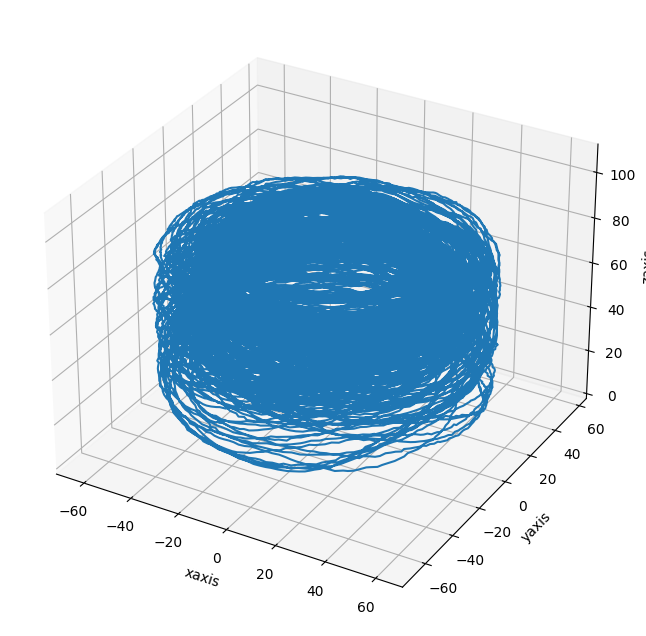